<a href="https://colab.research.google.com/github/uptrain-ai/uptrain/blob/main/examples/experiments/context_quality_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center">
  <a href="https://uptrain.ai">
    <img width="300" src="https://user-images.githubusercontent.com/108270398/214240695-4f958b76-c993-4ddd-8de6-8668f4d0da84.png" alt="uptrain">
  </a>
</h1>

# Context Quality Comparison 

**Overview**: In this notebook, we will compare the quality of retrieved context from Cohere's and OpenAI's embedding models. We have used cosine similarity metric to retrieve the context from the given corpus.

We have used Uptrain Standard Eval - Context Relevance to make a judegement on which model is good for the context retrieval purpose.


Embed v3 is cohere's latest and most advanced embeddings model. Embed v3 offers state-of-the-art performance per trusted MTEB and BEIR benchmarks. One of the key improvements in Embed v3 is its ability to evaluate how well a query matches a document's topic and assesses the overall quality of the content. This means that it can rank the highest-quality documents at the top, which is especially helpful when dealing with noisy datasets.

On the other hand, OpenAI's text-embedding-ada-002 outperforms all the old embedding models on text search, code search, and sentence similarity tasks and gets comparable performance on text classification. 

For our evaluations, we have used Financial QA dataset. The FiQA dataset has roughly 6,000 questions and 57,000 answers. Financial QA is hard because the vocabularies are context specific. In this experiment, we have randomly picked 100 questions and performed our evaluations on top of it. 

In [1]:
import json 
import polars as pl
import os

url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/context_quality_analysis.jsonl"
dataset_path = os.path.join('./', "context_quality_analysis.jsonl")

if not os.path.exists(dataset_path):
    import httpx
    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)
        


In [2]:
dataset= pl.read_ndjson(dataset_path)

In [3]:
dataset

question,ground_truth,context,embedding_model
str,str,str,str
"""Am I exposed t…","""""Yes, you're s…","""The value of a…","""cohere"""
"""Am I exposed t…","""""Yes, you're s…","""Your definitio…","""openai"""
"""What happen in…","""""But what happ…","""If you sold bo…","""cohere"""
"""What happen in…","""""But what happ…","""1) Yes, both o…","""openai"""
"""How to use a c…","""""You must buy …","""""You must buy …","""cohere"""
"""How to use a c…","""""You must buy …","""""You must buy …","""openai"""
"""Where do I fin…","""I agree that a…","""""These warrant…","""cohere"""
"""Where do I fin…","""I agree that a…","""""These warrant…","""openai"""
"""How do we know…","""For a company …","""Generally the …","""cohere"""


In [4]:
len(dataset)

200

In [5]:
dataset = dataset.to_dicts()

## Running Uptrain Eval - Context Relevancy

### OpenAI Embeddings

In [6]:
from uptrain import EvalLLM, Evals, ResponseMatching
import nest_asyncio
nest_asyncio.apply()

OPENAI_API_KEY = "sk-**************"  ## INSERT YOUR OpenAI KEY HERE

eval_llm = EvalLLM(openai_api_key=OPENAI_API_KEY)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pydantic/_internal/_fields.py:151: UserWarning: Field "model_purpose" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


In [7]:
dataset[1].keys()

dict_keys(['question', 'ground_truth', 'context', 'embedding_model'])

In [8]:
results = eval_llm.evaluate_experiments(
    project_name="context_quality_comparison",
    data = dataset, 
    checks = [Evals.CONTEXT_RELEVANCE], 
    exp_columns = ['embedding_model']
)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [03:03<00:00,  1.09it/s]


We have used UpTrain's **Context Relevance** evaluation to evaluate the quality of context retrieval, you can read more about it in our documentation [here](https://docs.uptrain.ai/predefined-evaluations/context-awareness/context-relevance)

## Comparitive Analysis

In [9]:
results[7]['question']

'How do I pay my estimated income tax?'

To print context from both models, please uncomment and run the next cell.

In [10]:
# print('Question:', results[7]['question'])
# print('Cohere context:', results[7]['context_embedding_model_cohere'])
# print()
# print('OpenAI context:', results[7]['context_embedding_model_openai'])

In this example, we can clearly see that the context retrieved from the cohere's embed v3 model has all the required content to answer this particular question. For instance, the notion of 'self-employment' tax is only retrieved in cohere's model context whereas OpenAI's model context does not mention about this particular tax. 

OpenAI context contains relevant information to answer this question but Cohere's context is much better to answer this question from holistic view.


In [11]:
print('Context Relevance Score using Embed v3 model:', results[7]['score_context_relevance_embedding_model_cohere'])
print('Context Relevance Score using OpenAI model:', results[7]['score_context_relevance_embedding_model_openai'])

Context Relevance Score using Embed v3 model: 1.0
Context Relevance Score using OpenAI model: 0.5


The same conclusion can be achieved by running the Uptrain Standard Eval - Context Relevance. We can see that the context retrieved from the embed v3 model has got a score of 1.0 while the context retrieved from the OpenAI embedding model has a score of 0.5. 


## Conclusion

In [12]:
score_context_relevance_openai = list(pl.DataFrame(results)['score_context_relevance_embedding_model_openai'])
score_context_relevance_cohere = list(pl.DataFrame(results)['score_context_relevance_embedding_model_cohere'])

In [13]:
print('Average Context Relevancy Score using OpenAI model:', sum(score_context_relevance_openai)/len(score_context_relevance_openai))
print('Average Context Relevancy Score using Embed v3 model:', sum(score_context_relevance_cohere)/len(score_context_relevance_cohere))

Average Context Relevancy Score using OpenAI model: 0.535
Average Context Relevancy Score using Embed v3 model: 0.585


Empirically, this shows that the context retrieved from the Embed v3 model is of better quality in comparison to the OpenAI embedding model. 

The same analysis can be seen from the graph as well. The graph can be obtained from Uptrain dashboard by providing the uptrain API key.

### Visualize Results

You can also visualize these results using our dashboards.

These dashboards are a part of our Open Source Offering. You can check it out on our [Github](https://github.com/uptrain-ai/uptrain).

You can run these dashboards locally on your system, check out our [documentation](https://docs.uptrain.ai/dashboard/getting_started) to get started.

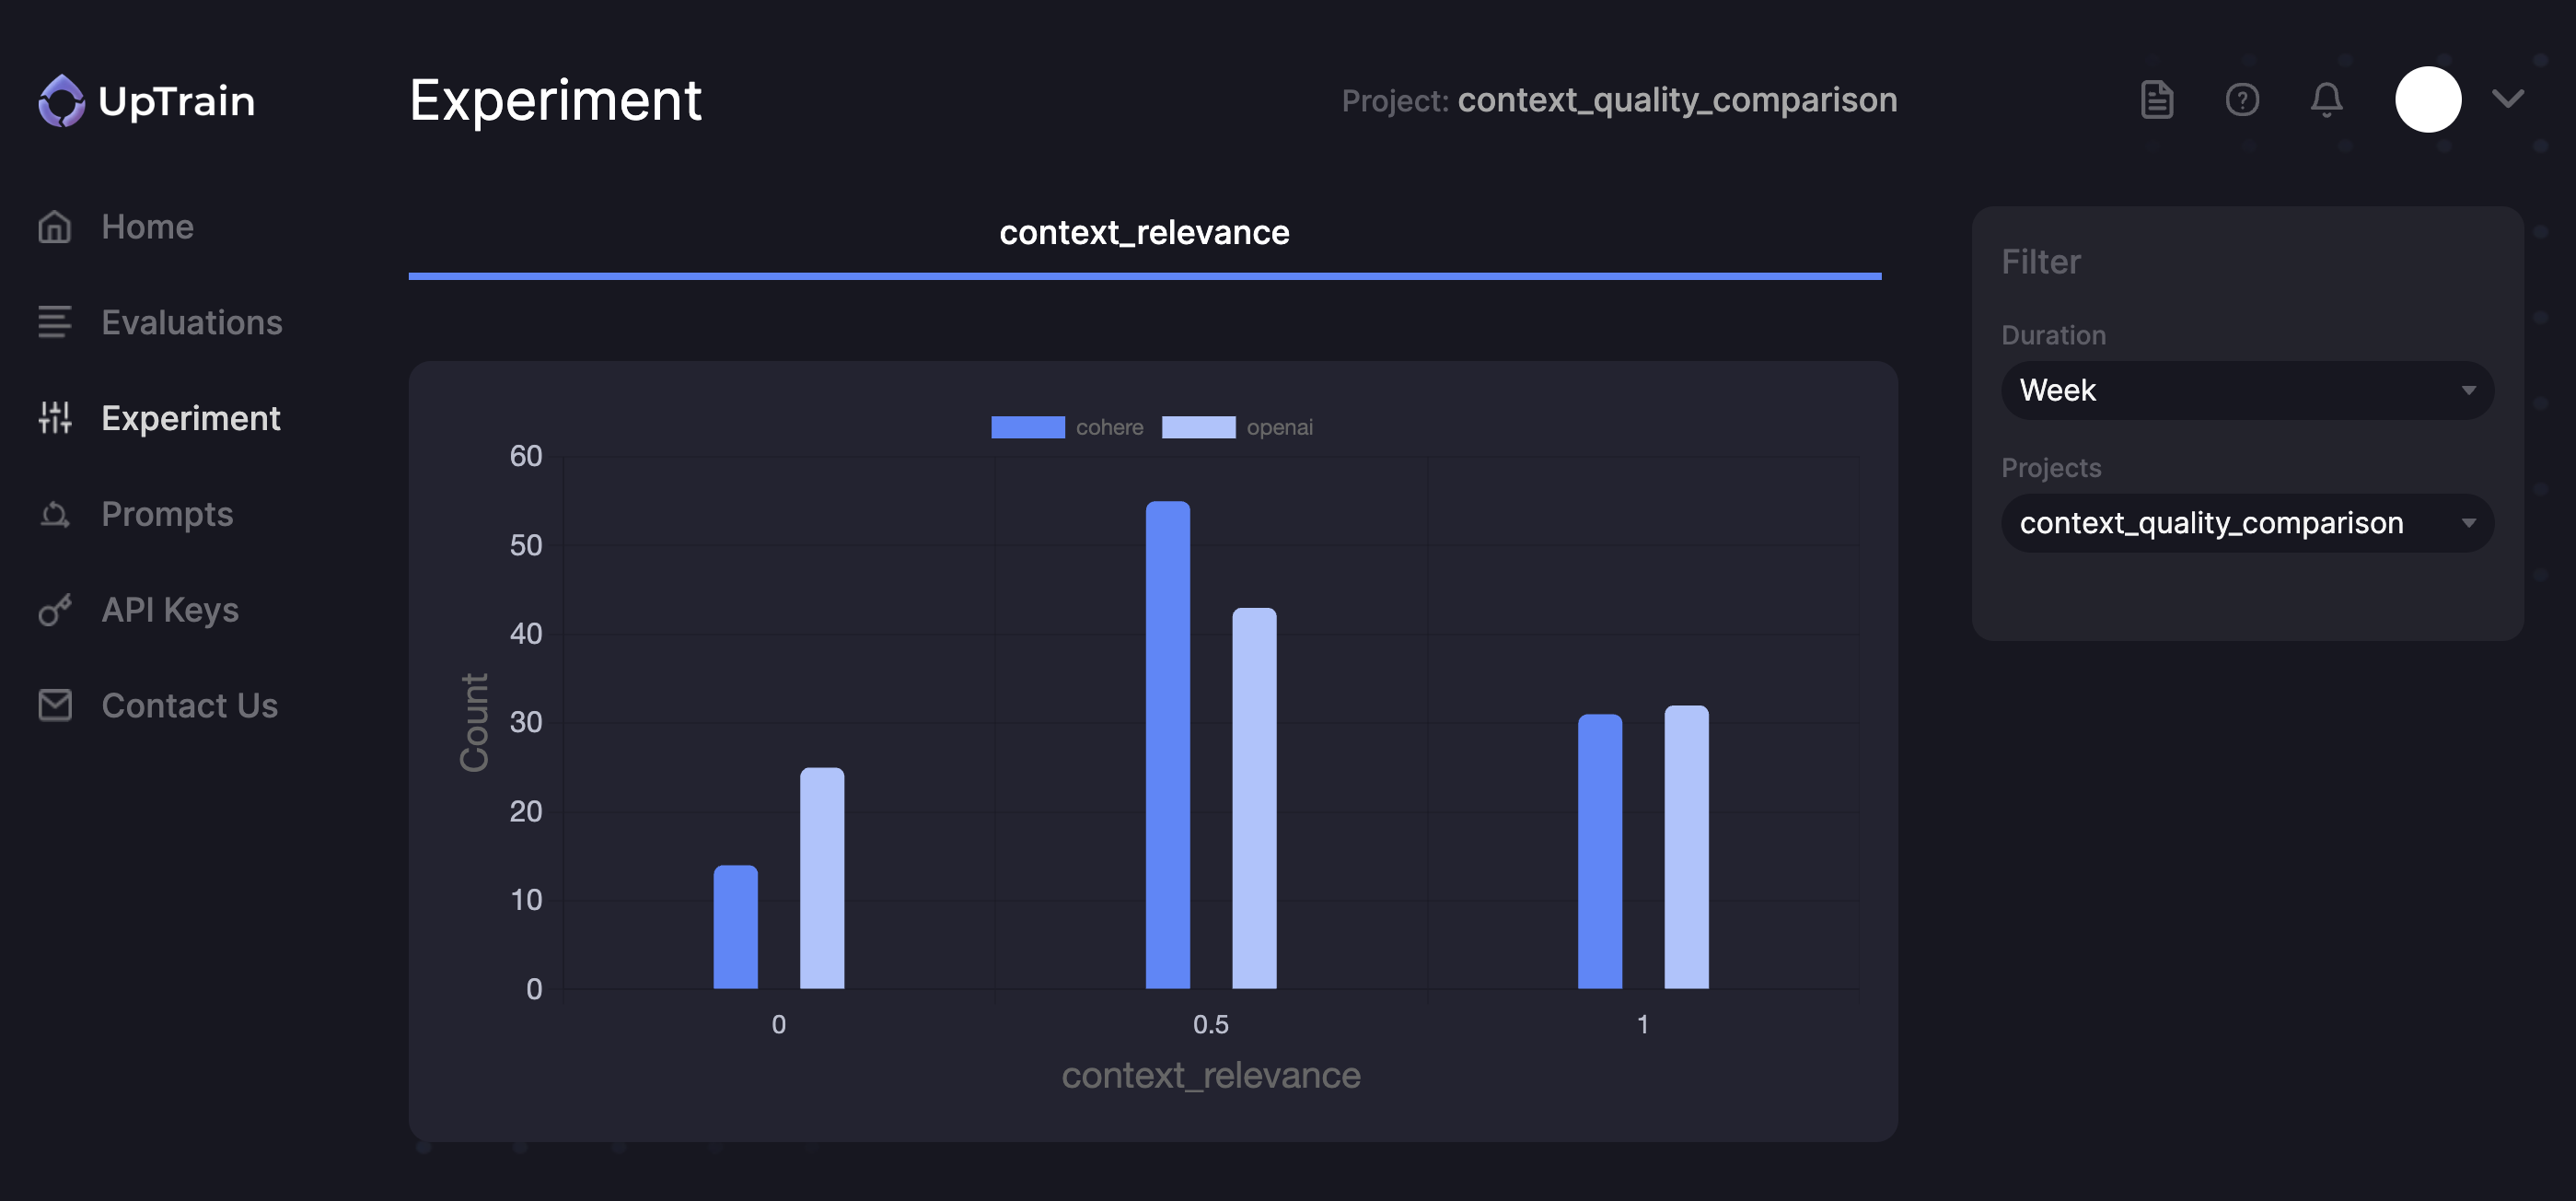

Using UpTrain dashboards you can also see logs of individual data points and get key insights

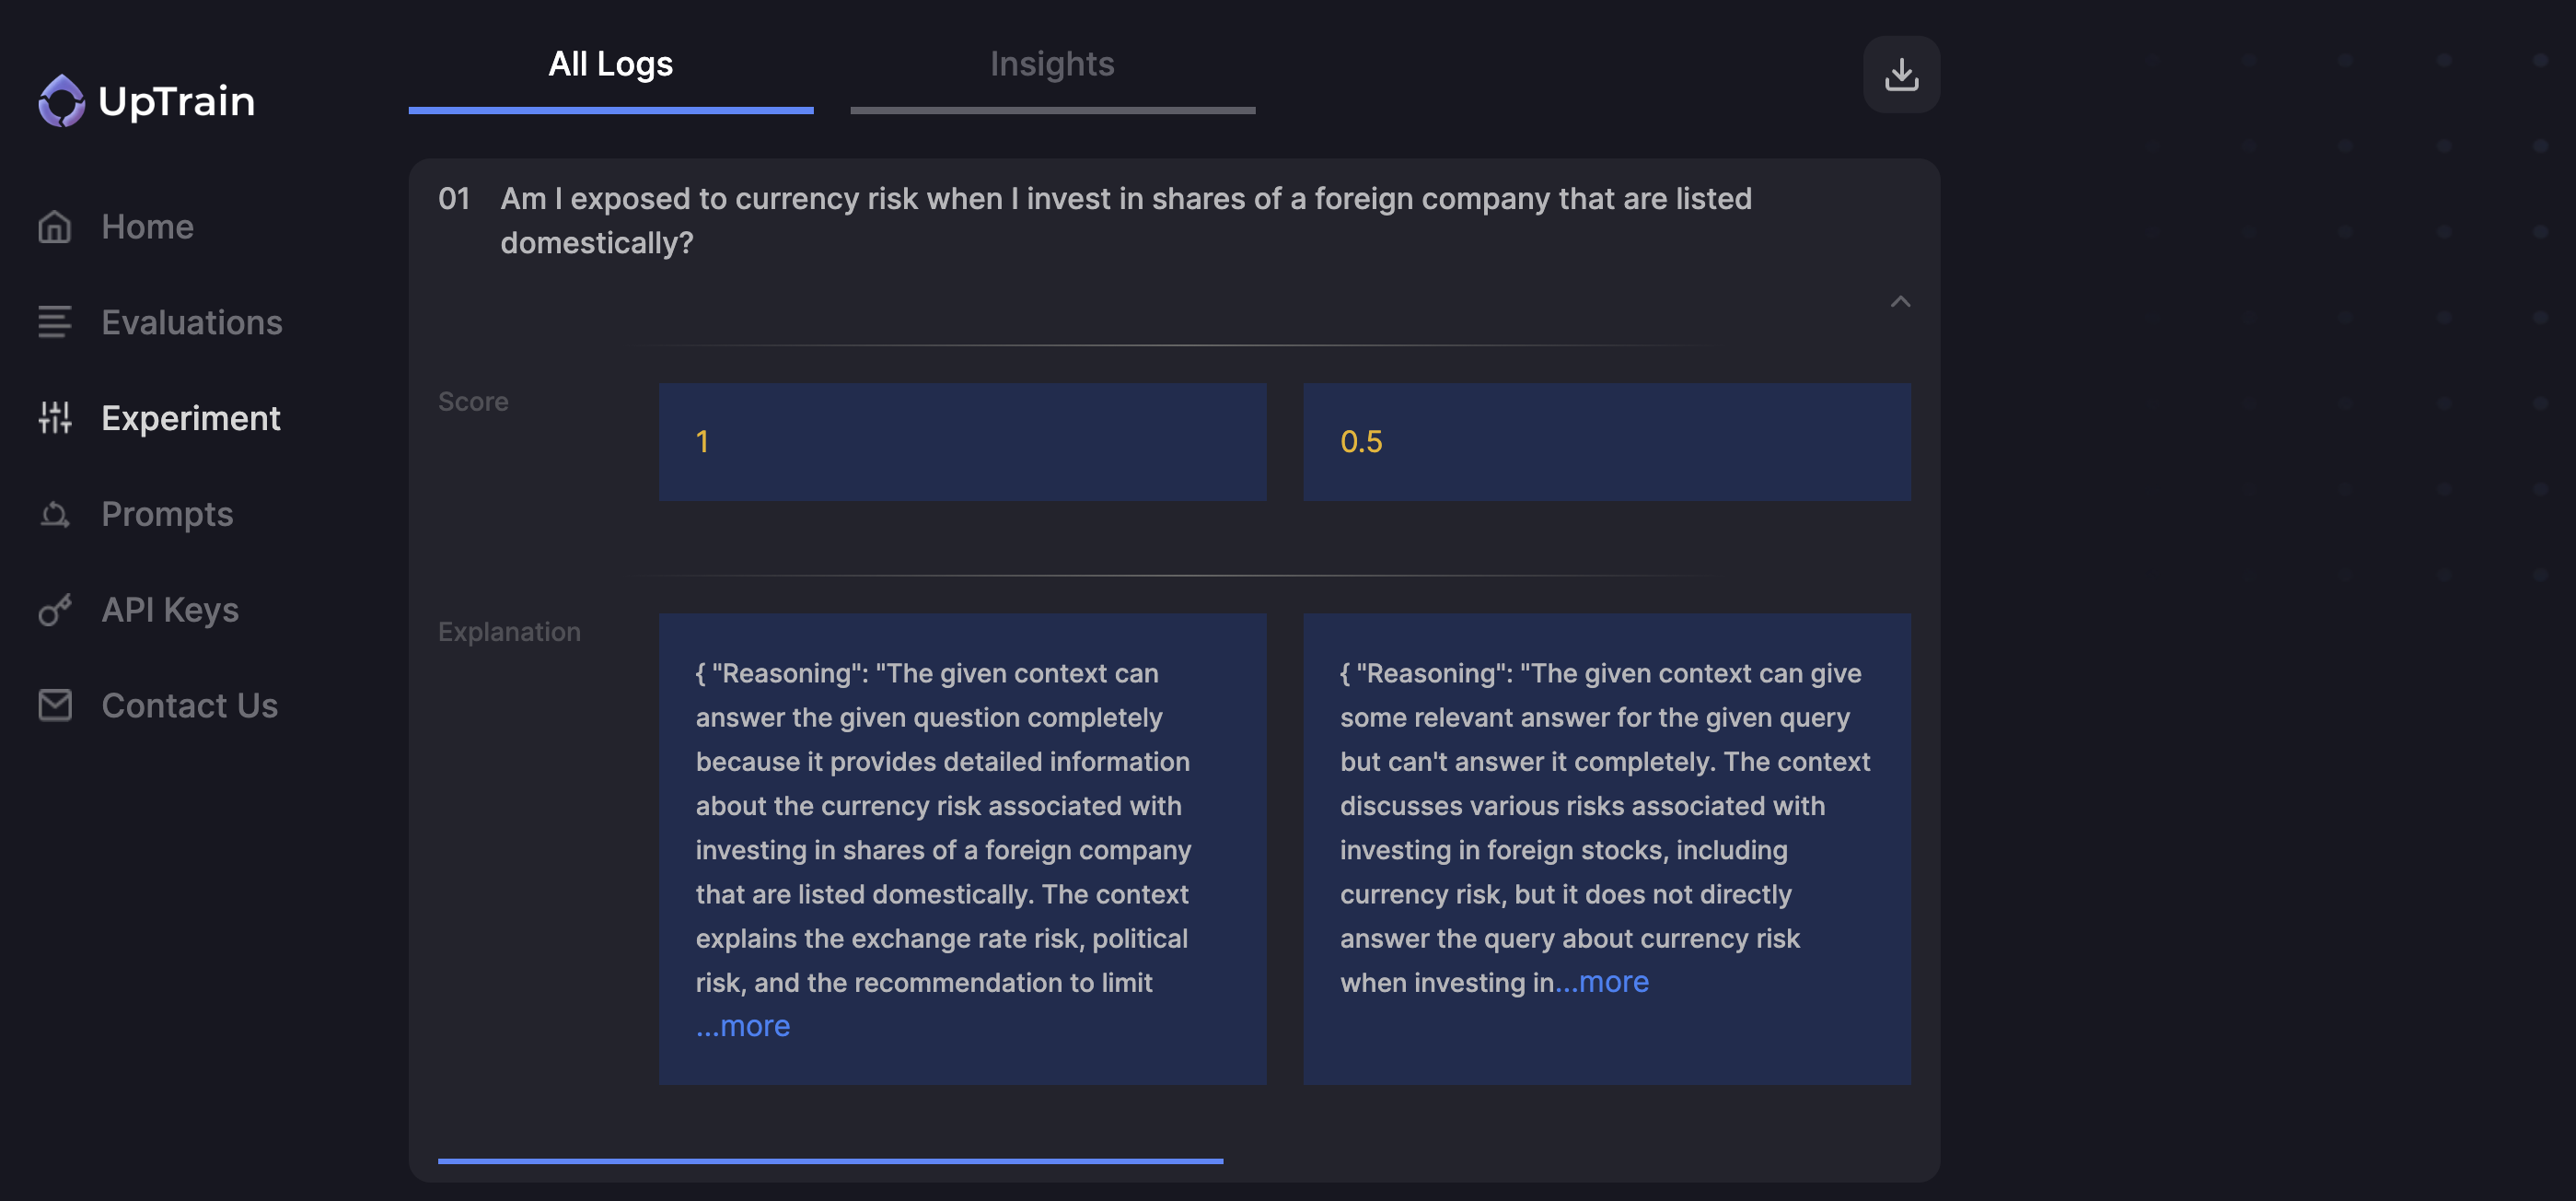